### How are in-demand skills trending for Machine Learning Engineers?

#### Methology
1. Aggregate skill counts monthly
2. Re-analyze based on percentage of total jobs
3. Plot the monthly skill demand


In [1]:
# Let's load teh datasets for our analysis.
!pip install -q datasets
!pip install -q adjustText
!pip install -q requests

### Import Libraries

In [2]:
## Importing all of the necessary libraries including the dataset
import ast
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from adjustText import adjust_text
import requests # to get the continents for the jobs

### Load Datasets

In [3]:
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

### Data Cleaning and Issues

- Wrong datatype for job_posted_date column
- Job skills column is in dictionary format.

In [4]:
# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

df.head(3)

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_rate,salary_year_avg,salary_hour_avg,company_name,job_skills,job_type_skills
0,Senior Data Engineer,Senior Clinical Data Engineer / Principal Clin...,"Watertown, CT",via Work Nearby,Full-time,False,"Texas, United States",2023-06-16 13:44:15,False,False,United States,None,NaN,NaN,Boehringer Ingelheim,None,None
1,Data Analyst,Data Analyst,"Guadalajara, Jalisco, Mexico",via BeBee México,Full-time,False,Mexico,2023-01-14 13:18:07,False,False,Mexico,None,NaN,NaN,Hewlett Packard Enterprise,"[r, python, sql, nosql, power bi, tableau]","{'analyst_tools': ['power bi', 'tableau'], 'pr..."
2,Data Engineer,"Data Engineer/Scientist/Analyst, Mid or Senior...","Berlin, Germany",via LinkedIn,Full-time,False,Germany,2023-10-10 13:14:55,False,False,Germany,None,NaN,NaN,ALPHA Augmented Services,"[python, sql, c#, azure, airflow, dax, docker,...","{'analyst_tools': ['dax'], 'cloud': ['azure'],..."


In [5]:
# country for analysis and per continent analysis as well
df_country = df['job_country'].value_counts().to_frame(name='count')
df_country.reset_index(inplace=True)
df_country.rename(columns={'index':'Country'},inplace=True)
df_country.drop(columns='count',inplace=True)
df_country.head()

,Country
0,United States
1,India
2,United Kingdom
3,France
4,Germany


In [6]:
def get_continent(country):
    try:
        # Use the RestCountries API to fetch country information
        response = requests.get(f'https://restcountries.com/v3.1/name/{country}')
        data = response.json()
        return data[0]['continents'][0]  
    except Exception as e:
        return 'Unknown'


# Apply the function to the job_country column
df_country['continent'] = df_country['Country'].apply(get_continent)

In [7]:

fix_continents = {
    "United States": "North America",
    "Australia": "Oceania",
    "New Zealand": "Oceania",
    "Guam": "Oceania",
    "U.S. Virgin Islands": "North America",
    "Macedonia (FYROM)": "Europe",
    "Congo, Democratic Republic of the": "Africa",
    "Fiji": "Oceania",
    "Papua New Guinea": "Oceania",
    "Northern Mariana Islands": "Oceania"
}

# Update the continent column based on the mapping
df_country['continent'] = df_country['Country'].map(fix_continents).fillna(df_country['continent'])

In [8]:
df_merged = df.merge(df_country, how='left',left_on='job_country',right_on='Country')
df_merged.head(3)

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_rate,salary_year_avg,salary_hour_avg,company_name,job_skills,job_type_skills,Country,continent
0,Senior Data Engineer,Senior Clinical Data Engineer / Principal Clin...,"Watertown, CT",via Work Nearby,Full-time,False,"Texas, United States",2023-06-16 13:44:15,False,False,United States,None,NaN,NaN,Boehringer Ingelheim,None,None,United States,North America
1,Data Analyst,Data Analyst,"Guadalajara, Jalisco, Mexico",via BeBee México,Full-time,False,Mexico,2023-01-14 13:18:07,False,False,Mexico,None,NaN,NaN,Hewlett Packard Enterprise,"[r, python, sql, nosql, power bi, tableau]","{'analyst_tools': ['power bi', 'tableau'], 'pr...",Mexico,North America
2,Data Engineer,"Data Engineer/Scientist/Analyst, Mid or Senior...","Berlin, Germany",via LinkedIn,Full-time,False,Germany,2023-10-10 13:14:55,False,False,Germany,None,NaN,NaN,ALPHA Augmented Services,"[python, sql, c#, azure, airflow, dax, docker,...","{'analyst_tools': ['dax'], 'cloud': ['azure'],...",Germany,Europe


#### Group the Skills by Month

Select only those job postings that are for Machine Learning Engineers / Data Scientists and the job continent which is Africa. So we'll have to datasets. Then extract the month from each job's posting date to see when jobs are listed. Next, converts a column that lists skills into a usable list format. Finally, it rearranges the data so that each skill from the list gets its own row.

In [9]:
## Skill count per month for MLEs
df_ml = df_merged[df_merged['job_title'].isin(['Data Scientist','Machine Learning Engineer'])].copy()

df_ml['job_posted_month_no'] = df_ml['job_posted_date'].dt.month

# Explode job_skills column
df_ml_explode = df_ml.explode('job_skills')

#### Africa

In [10]:
## Skill count per month for MLEs
df_ml_africa = df_merged[(df_merged['job_title'].isin(['Data Scientist','Machine Learning Engineer'])) & (df_merged['continent'] == 'Africa')].copy()
df_ml_africa['job_posted_month_no'] = df_ml_africa['job_posted_date'].dt.month

# Explode job_skills column
df_ml_africa_explode = df_ml_africa.explode('job_skills')

df_ml_africa_explode.head(3)

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_rate,salary_year_avg,salary_hour_avg,company_name,job_skills,job_type_skills,Country,continent,job_posted_month_no
62,Data Scientist,Data Scientist,"Austin, TX",via BeBee,Full-time,False,Sudan,2023-02-17 14:01:39,False,True,Sudan,None,NaN,NaN,ClosedLoop,python,"{'programming': ['python', 'go']}",Sudan,Africa,2
62,Data Scientist,Data Scientist,"Austin, TX",via BeBee,Full-time,False,Sudan,2023-02-17 14:01:39,False,True,Sudan,None,NaN,NaN,ClosedLoop,go,"{'programming': ['python', 'go']}",Sudan,Africa,2
105,Data Scientist,Data Scientist,"Aurora, CO",via Higher Ed Jobs,Full-time,False,Sudan,2023-07-20 13:59:37,False,True,Sudan,None,NaN,NaN,University of Colorado Anschutz Medical Campus,python,"{'cloud': ['aurora'], 'libraries': ['numpy', '...",Sudan,Africa,7


### Pivot in Prep for Plotting

Create a pivot table from the `df_ml_pivot`, setting 'month' as the index, `job_skills` as the columns, and fills missing entries with zero. Do the same with the African dataset as well.

In [11]:
# Group by month and job_skills
df_ml_pivot = df_ml_explode.pivot_table(index='job_posted_month_no', columns='job_skills',  aggfunc='size', fill_value=0)

df_ml_africa_pivot = df_ml_africa_explode.pivot_table(index='job_posted_month_no', columns='job_skills',  aggfunc='size', fill_value=0)

##### Sort columns by count and change month numbers to names

It adds a new row labeled `Total` that sums up counts across all months for each skill. Finally, it reorders the columns based on the total counts, displaying them from highest to lowest, and shows the updated pivot table. 

In [12]:
# sorts by count
df_ml_pivot.loc['Total'] = df_ml_pivot.sum()
df_ml_pivot = df_ml_pivot[df_ml_pivot.loc['Total'].sort_values(ascending=False).index]
df_ml_pivot = df_ml_pivot.drop('Total')

# sorts by count for Africa
df_ml_africa_pivot.loc['Total'] = df_ml_africa_pivot.sum()
df_ml_africa_pivot = df_ml_africa_pivot[df_ml_africa_pivot.loc['Total'].sort_values(ascending=False).index]
df_ml_africa_pivot = df_ml_africa_pivot.drop('Total')


#### Plot the Monthly Skill Counts

Plot a line chart of the top 5 skills for machine learning engineers, indexed by month. It selects the first five columns and plots them. 

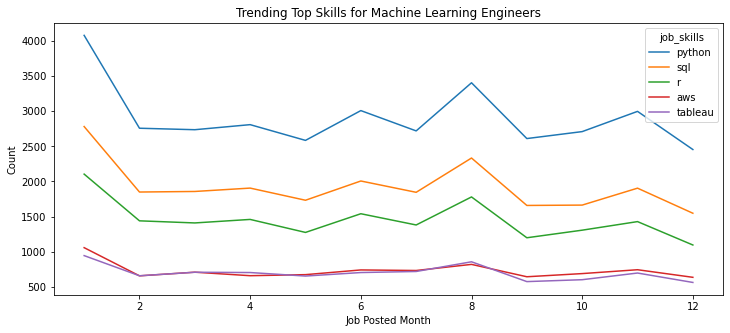

In [13]:
df_ml_pivot.iloc[:, :5].plot(kind='line',figsize=(12, 5))

plt.title('Trending Top Skills for Machine Learning Engineers')
plt.ylabel('Count')
plt.xlabel('Job Posted Month')
plt.show();

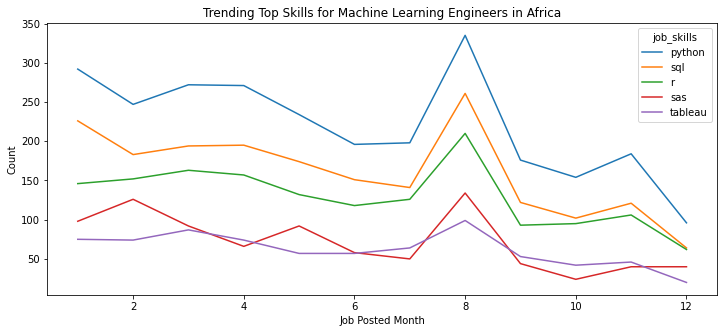

In [14]:
df_ml_africa_pivot.iloc[:, :5].plot(kind='line',figsize=(12, 5))

plt.title('Trending Top Skills for Machine Learning Engineers in Africa')
plt.ylabel('Count')
plt.xlabel('Job Posted Month')
plt.show();

This is good but totals can be misleading without context. Percentages clarify relationships within the whole, giving a more accurate comparison.

#### Calculate Percentage of Total Jobs

**Calculates** the total number of entries for each month in `df_ml` by grouping the data by 'month' and counting the number of occurrences in each group, storing the results in `ml_totals`. This is needed to compute the percentages.

In [15]:
# Get monthly totals
ml_totals = df_ml.groupby('job_posted_month_no').size()

ml_africa_totals = df_ml_africa.groupby('job_posted_month_no').size()

ml_africa_totals

job_posted_month_no
1     400
2     322
3     348
4     357
5     324
6     271
7     267
8     438
9     262
10    212
11    240
12    151
dtype: int64

This code calculates the percentage of each skill's occurrence for each month by dividing the first 12 rows of the `df_ml_pivot` DataFrame, which contains skill counts, by the monthly totals in `ml_totals` and multiplying by 100. The new DataFrame, `df_ml_pivot_percent`, shows skill distributions as percentages of total monthly job entries. Will do the same for the Africa dataset as well.

In [16]:
# divide first 12 rows of df_ml_pivot by ml_totals
df_ml_percent = df_ml_pivot.iloc[:12].div(ml_totals/100, axis=0)

# changes month number to month name
df_ml_percent = df_ml_percent.reset_index()
df_ml_percent['job_posted_month'] = df_ml_percent['job_posted_month_no'].apply(lambda x: pd.to_datetime(x, format='%m').strftime('%b'))
df_ml_percent = df_ml_percent.set_index('job_posted_month')
df_ml_percent = df_ml_percent.drop(columns='job_posted_month_no')


# divide first 12 rows of df_DA_pivot_africa by ml_totals
df_ml_africa_percent = df_ml_africa_pivot.iloc[:12].div(ml_africa_totals/100, axis=0)

# changes month number to month name
df_ml_africa_percent = df_ml_africa_percent.reset_index()
df_ml_africa_percent['job_posted_month'] = df_ml_africa_percent['job_posted_month_no'].apply(lambda x: pd.to_datetime(x, format='%m').strftime('%b'))
df_ml_africa_percent = df_ml_africa_percent.set_index('job_posted_month')
df_ml_africa_percent = df_ml_africa_percent.drop(columns='job_posted_month_no')

In [17]:
df_ml_africa_percent

job_skills,python,sql,r,sas,tableau,aws,spark,java,azure,tensorflow,...,trello,colocation,svelte,couchdb,solidity,smartsheet,heroku,kotlin,mlpack,erlang
job_posted_month,,,,,,,,,,,,,,,,,,,,,
Jan,73.000000,56.500000,36.500000,24.500000,18.750000,19.250000,21.500000,13.500000,14.750000,12.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.25,0.000000,0.25,0.000000,0.000000
Feb,76.708075,56.832298,47.204969,39.130435,22.981366,17.080745,19.254658,14.596273,16.149068,13.975155,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.310559
Mar,78.160920,55.747126,46.839080,26.436782,25.000000,20.114943,15.229885,15.517241,16.091954,10.919540,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.287356,0.00,0.000000,0.000000
Apr,75.910364,54.621849,43.977591,18.487395,20.728291,18.767507,17.366947,16.246499,13.165266,12.044818,...,0.000000,0.280112,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000
May,72.222222,53.703704,40.740741,28.395062,17.592593,18.518519,15.432099,12.654321,12.962963,8.024691,...,0.000000,0.000000,0.308642,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000
Jun,72.324723,55.719557,43.542435,21.402214,21.033210,13.653137,17.712177,14.391144,11.439114,14.760148,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000
Jul,74.157303,52.808989,47.191011,18.726592,23.970037,19.850187,14.232210,18.352060,13.857678,11.610487,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000
Aug,76.484018,59.589041,47.945205,30.593607,22.602740,15.525114,17.808219,14.383562,14.155251,11.187215,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000
Sep,67.175573,46.564885,35.496183,16.793893,20.229008,14.503817,14.122137,14.503817,11.450382,11.450382,...,0.000000,0.000000,0.000000,0.000000,0.381679,0.00,0.000000,0.00,0.000000,0.000000


#### Plot Monthly Skill Demand 

Creates a line plot for the top five skills of machine learning engineers, shown as percentages of the total job entries per month, using the first 5 columns of the `df_ml_pivot_percent` DataFrame. Also the legend is moved outside of the plot for readability.

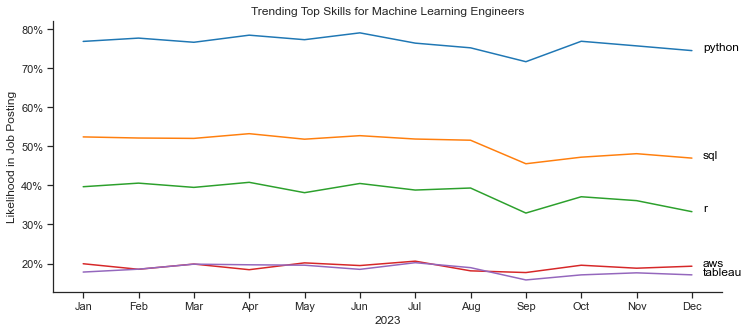

In [20]:
from matplotlib.ticker import PercentFormatter

df_plot = df_ml_percent.iloc[:, :5]
plt.figure(figsize=(12, 5))
sns.lineplot(data=df_plot, dashes=False, legend='full', palette='tab10')
sns.set_theme(style='ticks')
sns.despine() # remove top and right spines

plt.title('Trending Top Skills for Machine Learning Engineers')
plt.ylabel('Likelihood in Job Posting')
plt.xlabel('2023')
plt.legend().remove()
plt.gca().yaxis.set_major_formatter(PercentFormatter(decimals=0))

# annotate the plot with the top 5 skills using plt.text()
for i in range(5):
    plt.text(11.2, df_plot.iloc[-1, i], df_plot.columns[i], color='black')

plt.show()

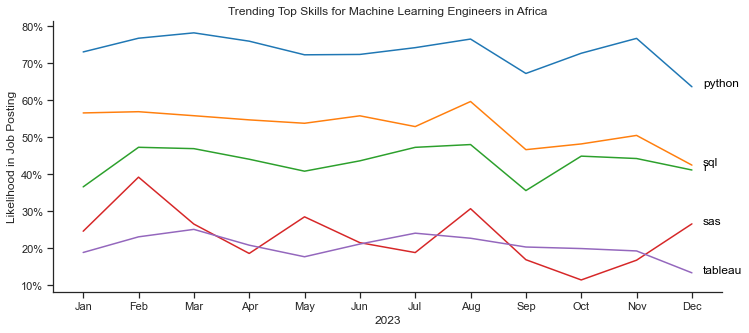

In [19]:
df_plot = df_ml_africa_percent.iloc[:, :5]
plt.figure(figsize=(12, 5))
sns.lineplot(data=df_plot, dashes=False, legend='full', palette='tab10')
sns.set_theme(style='ticks')
sns.despine() # remove top and right spines

plt.title('Trending Top Skills for Machine Learning Engineers in Africa')
plt.ylabel('Likelihood in Job Posting')
plt.xlabel('2023')
plt.legend().remove()
plt.gca().yaxis.set_major_formatter(PercentFormatter(decimals=0))

# annotate the plot with the top 5 skills using plt.text()
for i in range(5):
    plt.text(11.2, df_plot.iloc[-1, i], df_plot.columns[i], color='black')

plt.show()